In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('abc').getOrCreate()
spark

## PART 1 READ IN THE DATASETS
We have 7 datasets from the data source of U.S. Securities and Exchange Commission
First we read in the datasets we need and parse them. The followings are the 3 main data tables we used

### Table 1  company_submission
#### read in and parse

In [3]:
df1 = spark.read.csv('s3://sec-finc/t1/',header = False)

In [4]:
from pyspark.sql.functions import split, explode,col
col_names = ['accession_number_int','accession_number','cik','company_name',
             'filing_date','document_type','document_period_end_date','current_fiscal_year_end_date',
             'document_fiscal_year_focus','document_fiscal_period_focus','current_fiscal_year_end_month',
             'amendment_flag','assigned_sic','irs_number','state_of_incorporation','mailing_address_street1',
             'mailing_address_street2','mailing_address_city','mailing_address_state','mailing_address_zip',
             'business_address_street1','business_address_street2','business_address_city','business_address_state',
             'business_address_zip','mailing_phone_number','business_phone_number']
for i in range(0,len(col_names)):
    df1 = df1.withColumn(col_names[i], split(col("_c0"), "\t")[i]).cache()

In [5]:
df1 = df1.drop('_c0')
df1.first()

Row(accession_number_int='147793216011396', accession_number='0001477932-16-011396', cik='1528697', company_name='BOOKEDBYUS INC.', filing_date='2016-07-15', document_type='10-Q', document_period_end_date='2016-05-31', current_fiscal_year_end_date='--08-31', document_fiscal_year_focus='2016', document_fiscal_period_focus='Q3', current_fiscal_year_end_month='8', amendment_flag='false', assigned_sic='5045', irs_number='261679929 ', state_of_incorporation='NV', mailing_address_street1='619 S. RIDGELEY DRIVE', mailing_address_street2='\\N', mailing_address_city='LOS ANGELES', mailing_address_state='CA', mailing_address_zip='90036', business_address_street1='619 S. RIDGELEY DRIVE', business_address_street2='\\N', business_address_city='LOS ANGELES', business_address_state='CA', business_address_zip='90036', mailing_phone_number='\\N', business_phone_number='(323) 634-10')

#### Explore table 1

In [5]:
df1.createOrReplaceTempView('company_submission')

In [6]:
## number of companies:
spark.sql('''
    SELECT count(distinct a.company_name)
    FROM company_submission as a
''').show()

+----------------------------+
|count(DISTINCT company_name)|
+----------------------------+
|                       15807|
+----------------------------+



In [7]:
## type of document
spark.sql('''
    SELECT a.document_type,count(*) as cnt
    FROM company_submission as a
    group by a.document_type
    order by cnt DESC
''').show()

+-------------+----+
|document_type| cnt|
+-------------+----+
|         10-Q|9318|
|         10-K|8423|
|         null|5330|
|       10-Q/A|3103|
|       10-K/A|1558|
|         20-F| 847|
|       20-F/A| 338|
|         40-F| 149|
|        10-KT| 124|
|       40-F/A|  33|
|        10-QT|  27|
|      10-KT/A|  11|
|        424B3|   6|
|     10-12G/A|   3|
|      10-QT/A|   3|
|      DEF 14A|   1|
|       10-12G|   1|
|         10-D|   1|
+-------------+----+



Based on the distribution of type of document, we decided to only include 10-K, as it contained a wide range of annual financial data while most of the companies submitted the 10-K form.

In [19]:
## number of companies by year
nofcor_year = spark.sql('''
    SELECT a.document_fiscal_year_focus,count(distinct a.company_name) as cnt
    FROM company_submission as a
    where document_fiscal_year_focus>=2010 and document_fiscal_year_focus<=2019
    group by a.document_fiscal_year_focus
    order by document_fiscal_year_focus
''')
nofcor_year.show()

+--------------------------+----+
|document_fiscal_year_focus| cnt|
+--------------------------+----+
|                      2010|1327|
|                      2011|5775|
|                      2012|6444|
|                      2013|6037|
|                      2014|5757|
|                      2015|5416|
|                      2016|5043|
|                      2017|5147|
|                      2018|5032|
|                      2019|3944|
+--------------------------+----+



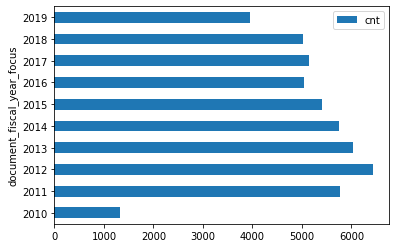

In [20]:
from matplotlib import pyplot as plt
##Visualizing number of companies submitted documents by year
nofcor_year=nofcor_year.toPandas()
nofcor_year.plot(kind='barh',x='document_fiscal_year_focus',y='cnt')

In [43]:
## number of companies by state
nofcor = spark.sql('''
    SELECT a.mailing_address_state as STUSPS,count(distinct a.company_name) as cnt
    FROM company_submission as a
    group by a.mailing_address_state
    order by cnt DESC
''')
nofcor.show()

+------+----+
|STUSPS| cnt|
+------+----+
|  null|7802|
|    CA|1270|
|    NY| 859|
|    TX| 719|
|    FL| 483|
|    NV| 337|
|    PA| 324|
|    MA| 323|
|    NJ| 310|
|    IL| 278|
|    \N| 257|
|    CO| 256|
|    A1| 214|
|    OH| 201|
|    VA| 184|
|    GA| 175|
|    A6| 171|
|    MN| 162|
|    NC| 157|
|    CT| 154|
+------+----+
only showing top 20 rows



In [35]:
# plot number of companies by state
import pandas as pd
from geopandas import GeoDataFrame

In [28]:
# load in shapefile
geo_df = GeoDataFrame.from_file('s3://sec-finc/shapefile/')

In [29]:
geo_df.columns

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')

In [30]:
geo_df.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [44]:
nofcor = nofcor.toPandas()

In [46]:
shape_df = geo_df.merge(nofcor, on='STUSPS',how ='inner')
shape_df.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,cnt
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",20
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",157
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",61
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",184
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",20


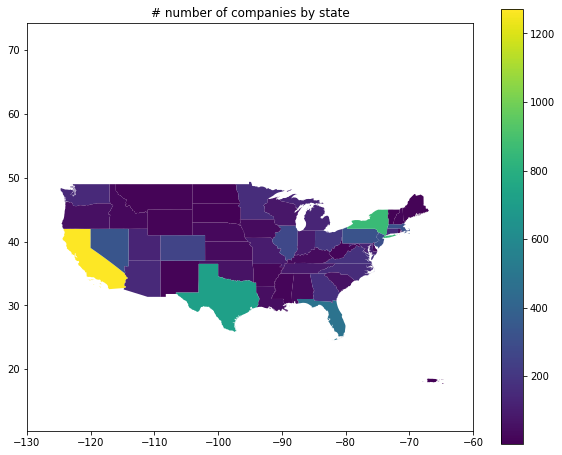

In [52]:
shape_df.plot(column='cnt',figsize=[10,8],legend = True)
plt.title('# number of companies by state')
plt.xlim(-130, -60) 
plt.show()

### Table 2  report_presentation_section
I     -  Statement of Income
IP    -  Statement of Income (Parenthetical)
CI    -  Statement of Comprehensive Income
CIP   -  Statement of Comprehensive Income (Parenthetical)
B     -  Balance Sheet
BP    -  Balance Sheet (Parenthetical)
C     -  Statement of Cash Flows
CP    -  Statement of Cash Flows (Parenthetical)
SE    -  Statement of Equity
SEP   -  Statement of Equity (Parenthetical)
#### read in and parse

In [7]:
df2 = spark.read.csv('s3://sec-finc/t2/',header = False)

In [8]:
from pyspark.sql.functions import split, explode,col
col_names1 = ['cik','filing_date','accession_number_int','section_sequence_id','statement_type','report_section_description']
for i in range(0,len(col_names1)):
    df2 = df2.withColumn(col_names1[i], split(col("_c0"), "\t")[i]).cache()
df2 = df2.drop('_c0')
df2.show()

+-------+-----------+--------------------+-------------------+--------------+--------------------------+
|    cik|filing_date|accession_number_int|section_sequence_id|statement_type|report_section_description|
+-------+-----------+--------------------+-------------------+--------------+--------------------------+
| 831259| 2010-11-05|      83125910000070|                 42|            \N|      Disclosure - ACCO...|
| 842162| 2018-10-25|      84216218000036|                 12|            \N|         Disclosure - Debt|
| 842162| 2018-10-25|      84216218000036|                 50|            \N|      Disclosure - Debt...|
| 842162| 2018-10-25|      84216218000036|                 74|            \N|      Disclosure - Fina...|
| 920448| 2014-11-06|      92044814000074|                 15|            \N|      Disclosure - Fair...|
| 920448| 2014-11-06|      92044814000074|                 25|            \N|      Disclosure - Comm...|
| 936395| 2015-06-10|      93639515000038|             

#### Explore Table2

In [9]:
df2.createOrReplaceTempView('report_section')

In [12]:
## number of documents by statement type
nofcor_year = spark.sql('''
    SELECT statement_type,count(accession_number_int) as cnt
    FROM report_section
    group by statement_type
    order by cnt DESC
''')
nofcor_year.show()

+--------------+--------+
|statement_type|     cnt|
+--------------+--------+
|            \N|10857756|
|             B|  242149|
|             C|  240038|
|            BP|  226214|
|             I|  199841|
|            SE|  151089|
|            CI|  134102|
|           SEP|   47356|
|           CIP|   27601|
|            IP|   15550|
|            CP|   15103|
+--------------+--------+



Based on this result, we only chose the most important and comprehensive statements: I, B, and C (income statement, balance sheet, and cash flow)

### Table 3 data_point

In [3]:
df3 = spark.read.csv('s3://sec-finc/t3/',header = False)

In [14]:
from pyspark.sql.functions import split, explode,col
col_names2 = ['cik','accession_number_int','filing_date','datapoint_id','datapoint_name','version',
              'segment_label','segment_hash','start_date','end_date','period_month','string_value','numeric_value',
              'decimals','unit','footnotes']
for i in range(0,len(col_names2)):
    df3 = df3.withColumn(col_names2[i], split(col("value"), "\t")[i]).cache()

In [15]:
df3 = df3.drop('value')

In [21]:
## look at the datapoint "NetIncomeLoss", our projected response
df3.createOrReplaceTempView('data_point')
NIL = spark.sql('''
    SELECT *
    FROM data_point as c
    Where datapoint_name =='NetIncomeLoss'
    limit 100
''')
NIL.show()

+-------+--------------------+-----------+------------+--------------+------------+--------------------+--------------------+----------+----------+------------+------------+-------------+--------+----+---------+
|    cik|accession_number_int|filing_date|datapoint_id|datapoint_name|     version|       segment_label|        segment_hash|start_date|  end_date|period_month|string_value|numeric_value|decimals|unit|footnotes|
+-------+--------------------+-----------+------------+--------------+------------+--------------------+--------------------+----------+----------+------------+------------+-------------+--------+----+---------+
| 885639|     156459019009005| 2019-03-22|  1082251202| NetIncomeLoss|us-gaap/2018|                  \N|                  \N|2018-02-04|2018-05-05|           3|    75000000|        7.5E7|      -6| USD|       \N|
|1572758|     157275813000011| 2013-11-13|   239064150| NetIncomeLoss|us-gaap/2013|                  \N|                  \N|2013-02-27|2013-09-30|     

By looking at the response, we noticed that files can represent different period of time, e.g. some of them are 3-month period and others are 12 months. Also, there're duplications. So, in our further data cleaning procedure, we mainly focused on those two issues.